# 示例：涡扇发动机-端到端-剩余使用寿命预测
- 数据集：C-MAPSS
- 模型：CNN
- 输入：滑动窗口样本（窗口大小：15、步长：1）
- 输出（RUL）：分段线性RUL
- 损失函数：均方误差
- 优化算法：随机梯度下降

In [1]:
import torch
from torch import nn

from fastphm.data import Dataset, TurbofanRulLabeler
from fastphm.data.loader.turbofan.CMAPSSLoader import CMAPSSLoader
from fastphm.metric.Evaluator import Evaluator
from fastphm.metric.end2end.MSE import MSE
from fastphm.metric.end2end.MAE import MAE
from fastphm.metric.end2end.PHM2008Score import PHM2008Score
from fastphm.metric.end2end.PHM2012Score import PHM2012Score
from fastphm.metric.end2end.PercentError import PercentError
from fastphm.metric.end2end.RMSE import RMSE
from fastphm.model.pytorch.base.BaseTester import BaseTester
from fastphm.model.pytorch.base.BaseTrainer import BaseTrainer
from fastphm.model.pytorch.callback.CheckGradientsCallback import CheckGradientsCallback
from fastphm.model.pytorch.callback.EarlyStoppingCallback import EarlyStoppingCallback
from fastphm.model.pytorch.callback.TensorBoardCallback import TensorBoardCallback
from fastphm.util.Plotter import Plotter

## 定义：提出的模型（仅供示例）

In [2]:
class ProposedModel(nn.Module):
    def __init__(self):
        super(ProposedModel, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(1, 3), padding=(0, 1), bias=False)
        self.conv1_1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=1, bias=False)
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(1, 3), padding=(0, 1), bias=False)
        self.conv2_1 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=1, bias=False)
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(1, 3), padding=(0, 1), bias=False)
        self.pool = nn.AvgPool2d(kernel_size=(1, 2), stride=2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64, 16)
        self.fc2 = nn.Linear(16, 1)

    def forward(self, x):
        x = x.unsqueeze(1)  # 增加通道维度，x的形状(批量，通道，传感器，时间)
        shortcut1 = x
        shortcut1 = self.conv1_1(shortcut1)
        x = self.conv1(x)
        x = torch.relu(x)
        x = x + shortcut1
        x = self.pool(x)
        shortcut2 = x
        shortcut2 = self.conv2_1(shortcut2)
        x = self.conv2(x)
        x = torch.relu(x)
        x = x + shortcut2
        x = self.pool(x)
        shortcut3 = x
        x = self.conv3(x)
        x = torch.relu(x)
        x = x + shortcut3
        x = self.pool(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = torch.relu(x)
        x = self.fc2(x)
        x = 125 * torch.sigmoid(x)
        return x

## 定义：必要组件
- 数据加载器，获取原始数据
- 标签器，用于生成训练数据和测试数据
- 需要去掉的恒定特征

In [3]:
data_loader = CMAPSSLoader('D:\\data\\dataset\\CMAPSSData')
columns_to_drop = [0, 1, 2, 3, 4, 8, 9, 13, 19, 21, 22]
feature_size = 14
Plotter.DPI = 80

[DEBUG   14:43:13]  
[DataLoader]  Root directory: D:\data\dataset\CMAPSSData
	✓ FD001_RUL, location: D:\data\dataset\CMAPSSData\RUL_FD001.txt
	✓ FD002_RUL, location: D:\data\dataset\CMAPSSData\RUL_FD002.txt
	✓ FD003_RUL, location: D:\data\dataset\CMAPSSData\RUL_FD003.txt
	✓ FD004_RUL, location: D:\data\dataset\CMAPSSData\RUL_FD004.txt
	✓ FD001_test, location: D:\data\dataset\CMAPSSData\test_FD001.txt
	✓ FD002_test, location: D:\data\dataset\CMAPSSData\test_FD002.txt
	✓ FD003_test, location: D:\data\dataset\CMAPSSData\test_FD003.txt
	✓ FD004_test, location: D:\data\dataset\CMAPSSData\test_FD004.txt
	✓ FD001_train, location: D:\data\dataset\CMAPSSData\train_FD001.txt
	✓ FD002_train, location: D:\data\dataset\CMAPSSData\train_FD002.txt
	✓ FD003_train, location: D:\data\dataset\CMAPSSData\train_FD003.txt
	✓ FD004_train, location: D:\data\dataset\CMAPSSData\train_FD004.txt


## 出图：涡扇发动机（原始数据）

[INFO    14:43:13]  [DataLoader]  -> Loading data entity: FD001_train_1
[INFO    14:43:13]  [DataLoader]  ✓ Successfully loaded: FD001_train_1


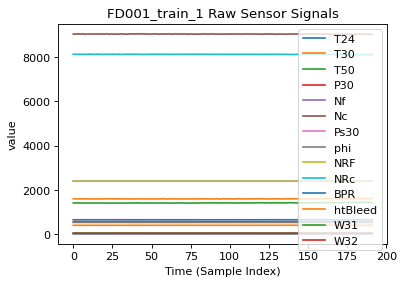

'FD001_train_1 Raw Sensor Signals'

In [4]:
turbofan = data_loader('FD001_train_1', columns_to_drop)
Plotter.raw(turbofan)

## 出图：涡扇发动机（归一化数据）

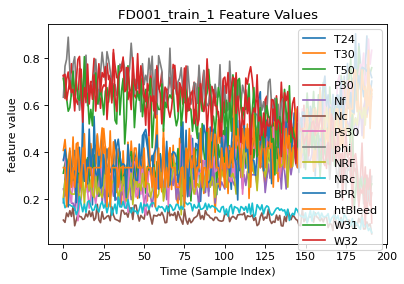

'FD001_train_1 Feature Values'

In [5]:
Plotter.feature(turbofan)

## 配置标签器

In [6]:
labeler_all_sample = TurbofanRulLabeler(window_size=30, window_step=1, max_rul=130)
labeler_last_sample = TurbofanRulLabeler(window_size=30, window_step=1, max_rul=130, last_sample=True)

## 生成训练数据

In [7]:
turbofans_train = data_loader.batch_load('FD001_train', columns_to_drop)
train_set = Dataset()
for turbofan in turbofans_train:
    train_set.add(labeler_all_sample(turbofan))

[INFO    14:43:14]  [DataLoader]  -> Loading data entity: FD001_train_1
[INFO    14:43:14]  [DataLoader]  ✓ Successfully loaded: FD001_train_1
[INFO    14:43:14]  [DataLoader]  -> Loading data entity: FD001_train_2
[INFO    14:43:14]  [DataLoader]  ✓ Successfully loaded: FD001_train_2
[INFO    14:43:14]  [DataLoader]  -> Loading data entity: FD001_train_3
[INFO    14:43:14]  [DataLoader]  ✓ Successfully loaded: FD001_train_3
[INFO    14:43:14]  [DataLoader]  -> Loading data entity: FD001_train_4
[INFO    14:43:14]  [DataLoader]  ✓ Successfully loaded: FD001_train_4
[INFO    14:43:14]  [DataLoader]  -> Loading data entity: FD001_train_5
[INFO    14:43:14]  [DataLoader]  ✓ Successfully loaded: FD001_train_5
[INFO    14:43:14]  [DataLoader]  -> Loading data entity: FD001_train_6
[INFO    14:43:14]  [DataLoader]  ✓ Successfully loaded: FD001_train_6
[INFO    14:43:14]  [DataLoader]  -> Loading data entity: FD001_train_7
[INFO    14:43:14]  [DataLoader]  ✓ Successfully loaded: FD001_train_7

## 生成测试数据

In [8]:
turbofan_test = data_loader.batch_load('FD001_test', columns_to_drop)
test_set_last_sample = Dataset()
test_set_all_sample = Dataset()
for turbofan in turbofan_test:
    test_set_last_sample.add(labeler_last_sample(turbofan))
    test_set_all_sample.add(labeler_all_sample(turbofan))
test_set_last_sample.name = 'FD001_test'

[INFO    14:43:15]  [DataLoader]  -> Loading data entity: FD001_test_1
[INFO    14:43:15]  [DataLoader]  ✓ Successfully loaded: FD001_test_1
[INFO    14:43:15]  [DataLoader]  -> Loading data entity: FD001_test_2
[INFO    14:43:15]  [DataLoader]  ✓ Successfully loaded: FD001_test_2
[INFO    14:43:15]  [DataLoader]  -> Loading data entity: FD001_test_3
[INFO    14:43:15]  [DataLoader]  ✓ Successfully loaded: FD001_test_3
[INFO    14:43:15]  [DataLoader]  -> Loading data entity: FD001_test_4
[INFO    14:43:15]  [DataLoader]  ✓ Successfully loaded: FD001_test_4
[INFO    14:43:15]  [DataLoader]  -> Loading data entity: FD001_test_5
[INFO    14:43:15]  [DataLoader]  ✓ Successfully loaded: FD001_test_5
[INFO    14:43:15]  [DataLoader]  -> Loading data entity: FD001_test_6
[INFO    14:43:15]  [DataLoader]  ✓ Successfully loaded: FD001_test_6
[INFO    14:43:15]  [DataLoader]  -> Loading data entity: FD001_test_7
[INFO    14:43:15]  [DataLoader]  ✓ Successfully loaded: FD001_test_7
[INFO    14:4

##　配置训练算法

In [9]:
trainer = BaseTrainer()

## 定义模型并训练

In [10]:
model = ProposedModel()
losses = trainer.train(model, train_set)

[INFO    14:43:16]  
[Trainer]  Start training by BaseTrainer:
	training set: FD001_train_1; FD001_train_2;…
	callbacks: []
	device: cuda
	dtype: torch.float32
	epochs: 100
	batch_size: 256
	criterion: MSELoss()
	lr: 0.01
	weight_decay: 0.0
	optimizer: Adam
[INFO    14:43:16]  [BaseTrainer]  Epoch [1/100], MSELoss:1270.8505
[INFO    14:43:16]  [BaseTrainer]  Epoch [2/100], MSELoss:565.5484
[INFO    14:43:16]  [BaseTrainer]  Epoch [3/100], MSELoss:466.0460
[INFO    14:43:17]  [BaseTrainer]  Epoch [4/100], MSELoss:440.7014
[INFO    14:43:17]  [BaseTrainer]  Epoch [5/100], MSELoss:424.5261
[INFO    14:43:17]  [BaseTrainer]  Epoch [6/100], MSELoss:419.4248
[INFO    14:43:17]  [BaseTrainer]  Epoch [7/100], MSELoss:430.0092
[INFO    14:43:17]  [BaseTrainer]  Epoch [8/100], MSELoss:416.4848
[INFO    14:43:18]  [BaseTrainer]  Epoch [9/100], MSELoss:412.4929
[INFO    14:43:18]  [BaseTrainer]  Epoch [10/100], MSELoss:425.5842
[INFO    14:43:18]  [BaseTrainer]  Epoch [11/100], MSELoss:417.8754
[I

## 出图：训练过程的损失变化

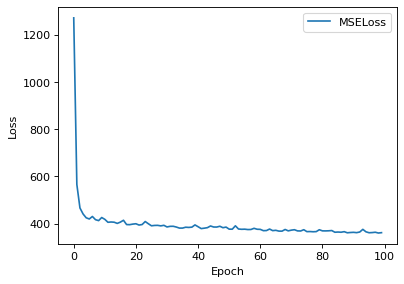

In [11]:
Plotter.loss(losses)

## 配置测试算法

In [12]:
tester = BaseTester()

## 配置评价指标

In [13]:
evaluator = Evaluator()
evaluator.add(MAE(), MSE(), RMSE(), PercentError(), PHM2012Score(), PHM2008Score())

## 仅测试最后一个时间窗口

In [14]:
result_last_sample = tester.test(model, test_set_last_sample)
evaluator(test_set_last_sample, result_last_sample, title='Evaluation of last sample')

[INFO    14:43:34]  
[Evaluator]  Evaluation of last sample:
                    MAE        MSE     RMSE PercentError PHM2012Score PHM2008Score
FD001_test_1     0.6895     0.4755   0.6895       -0.62%       0.9182       0.0714
FD001_test_2    14.7811   218.4795  14.7811      -15.08%       0.1236       3.3846
FD001_test_3     6.2267    38.7713   6.2267        9.02%       0.7314       0.6144
FD001_test_4     3.1929    10.1943   3.1929       -3.89%       0.5829       0.3761
FD001_test_5    17.3616   301.4268  17.3616      -19.08%       0.0710       4.6755
FD001_test_6     2.6245     6.8880   2.6245       -2.82%       0.6762       0.3001
FD001_test_7    13.8437   191.6475  13.8437      -15.21%       0.1214       2.9923
FD001_test_8     6.9051    47.6803   6.9051       -7.27%       0.3651       0.9947
FD001_test_9    10.4160   108.4935  10.4160       -9.38%       0.2723       1.8338
FD001_test_10    7.4050    54.8333   7.4050        7.71%       0.7654       0.7676
FD001_test_11   13.2405   

,MAE,MSE,RMSE,PercentError,PHM2012Score,PHM2008Score
FD001_test_1,0.6895,0.4755,0.6895,-0.62%,0.9182,0.0714
FD001_test_2,14.7811,218.4795,14.7811,-15.08%,0.1236,3.3846
FD001_test_3,6.2267,38.7713,6.2267,9.02%,0.7314,0.6144
FD001_test_4,3.1929,10.1943,3.1929,-3.89%,0.5829,0.3761
FD001_test_5,17.3616,301.4268,17.3616,-19.08%,0.0710,4.6755
...,...,...,...,...,...,...
FD001_test_98,48.0002,2304.0205,48.0002,-81.36%,0.0000,120.5130
FD001_test_99,7.6527,58.5639,7.6527,-6.54%,0.4038,1.1496
FD001_test_100,0.1520,0.0231,0.1520,0.76%,0.9740,0.0118
mean(global),13.1268,322.1261,17.9479,-6.15%,0.3530,789.7309


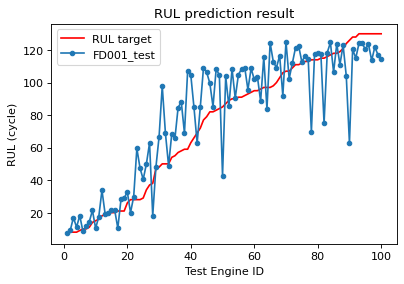

'RUL prediction result'

In [15]:
Plotter.rul_ascending(test_set_last_sample, result_last_sample,
                      is_scatter=False, label_x='Test Engine ID', label_y='RUL (cycle)')

## 测试所有时间窗口

In [16]:
result_all_sample = tester.test(model, test_set_all_sample)
evaluator(test_set_all_sample, result_all_sample, title='Evaluation of all sample')

[INFO    14:43:35]  
[Evaluator]  Evaluation of all sample:
                    MAE        MSE     RMSE PercentError PHM2012Score PHM2008Score
FD001_test_1     5.5828    55.1126   7.4238       -4.96%       0.5974       1.9222
FD001_test_2    10.7597   144.6743  12.0281       -8.06%       0.3698      45.4821
FD001_test_3    15.8296   383.9251  19.5940        7.10%       0.5082     575.3699
FD001_test_4    15.2107   352.4940  18.7748        4.67%       0.5297     394.3822
FD001_test_5    15.7945   426.1564  20.6436        8.37%       0.5723     737.1741
FD001_test_6    13.9969   304.8028  17.4586        7.22%       0.5943     332.7793
FD001_test_7     7.4107    70.7511   8.4114        3.75%       0.7609     129.5301
FD001_test_8    13.0505   256.1878  16.0059        9.05%       0.6773     442.4653
FD001_test_9    10.5069   177.6720  13.3294        6.64%       0.6988      56.6966
FD001_test_10   11.8821   192.4104  13.8712        8.49%       0.7106     334.6975
FD001_test_11   13.4982   2

,MAE,MSE,RMSE,PercentError,PHM2012Score,PHM2008Score
FD001_test_1,5.5828,55.1126,7.4238,-4.96%,0.5974,1.9222
FD001_test_2,10.7597,144.6743,12.0281,-8.06%,0.3698,45.4821
FD001_test_3,15.8296,383.9251,19.5940,7.10%,0.5082,575.3699
FD001_test_4,15.2107,352.4940,18.7748,4.67%,0.5297,394.3822
FD001_test_5,15.7945,426.1564,20.6436,8.37%,0.5723,737.1741
...,...,...,...,...,...,...
FD001_test_98,18.0092,462.0713,21.4958,-2.64%,0.4076,1054.0671
FD001_test_99,4.8026,24.6381,4.9637,3.10%,0.8544,31.8528
FD001_test_100,10.1735,162.7864,12.7588,-2.15%,0.5333,450.6575
mean(global),15.1480,384.9849,19.6210,2.27%,0.5293,131606.3934


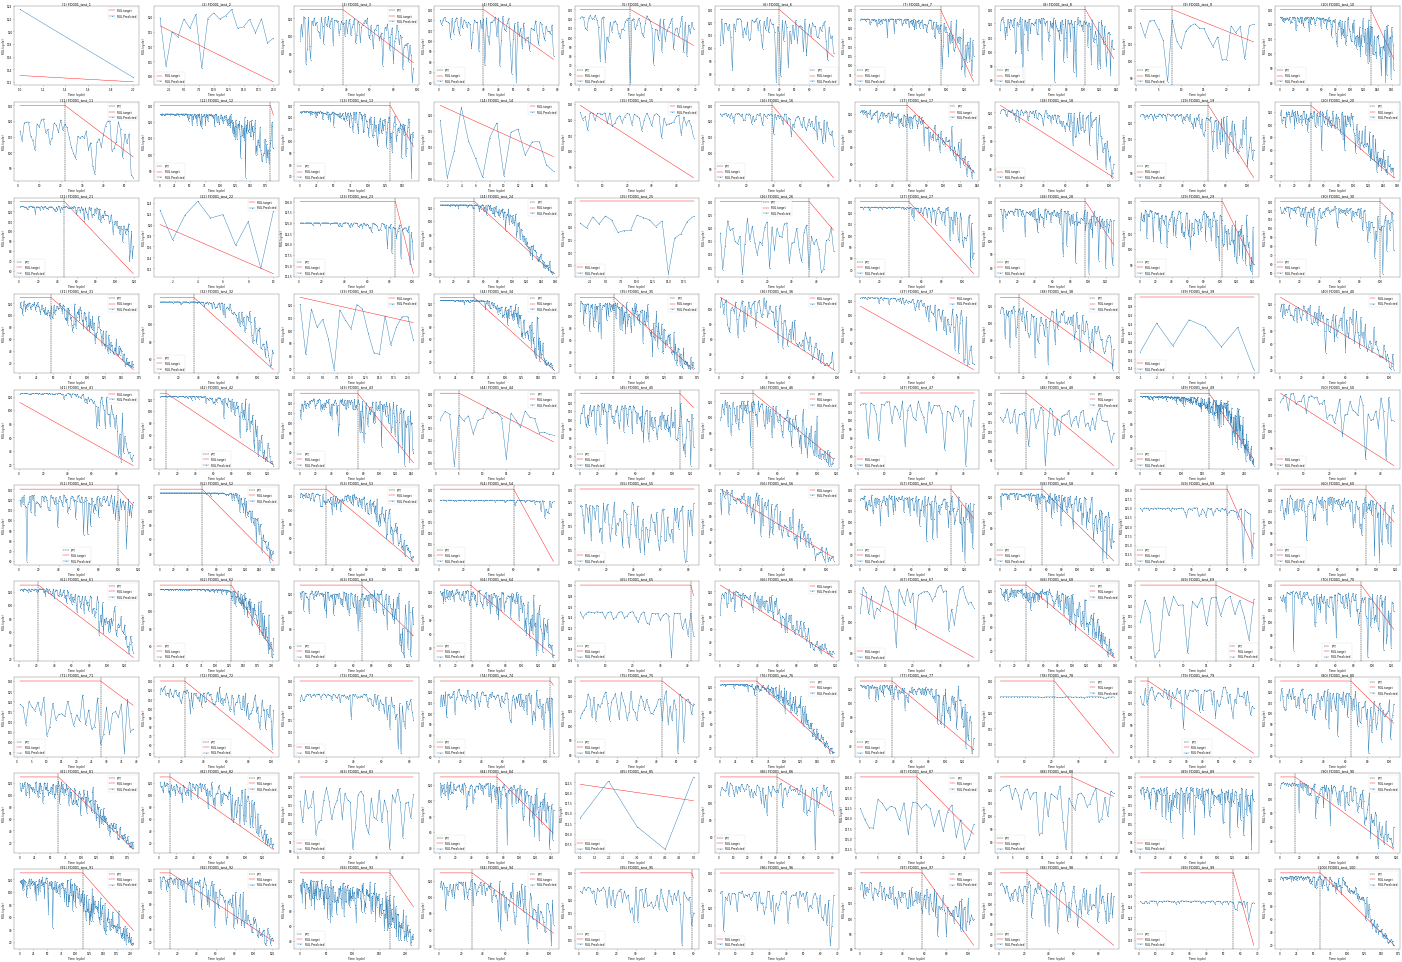

'default'

In [17]:
Plotter.reset()
Plotter.DPI = 20 #避免notebook太大
Plotter.rul_end2end(test_set_all_sample, result_all_sample,
                    is_scatter=False, label_x='Time (cycle)', label_y='RUL (cycle)')

## 仅绘图某个发动机预测结果

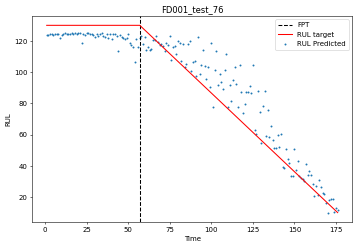

'default'

In [19]:
Plotter.reset()
Plotter.DPI = 50
Plotter.rul_end2end(test_set_all_sample.get('FD001_test_76'), result_all_sample.get('FD001_test_76'))